# FAST detector and BRIEF descriptor

This notebook presents implementation of FAST detector and BRIEF descriptor as separate python script.

Also there are some helper methods for blur addition, pixel restoration, etc.

In [4]:
import sys
import cv2
from matplotlib import pyplot as plt

sys.path.insert(0, '../helpers/')

In [5]:
%matplotlib inline

In [6]:
img_in_path = './res/tracking/'

## Feature detection using FAST

![Fast feature detector](fast_example.jpg)

*The highlighted squares are the pixels used in the corner detection. The pixel at p is the center of a candidate corner. The arc is indicated by the dashed line passes through 12 contiguous pixels which are brighter than p by more than the threshold.*

The general algorithm goes like this:
- Select a pixel **p** which is a point of interest in the image. The intensity of **p** is denoted as **Ip**.
- Select threshold value **t**. This value is used to detect the contiguous pixels, that are brighter that **p** by value **t**
- Concider a circle of 16 pixels around the interest pixel **p**. The circle is drawn with the **Midpoint circle algorithm** as it is **Bresenham circle**. 
- The pixel **p** is concidered a corner if there is a set of **n** contiguous pixels in the circle of 16 pixels (previous step) which are all brighter than the value **Ip + t** or darker than **Ip - t**
- We first check pixels 1,5,9,13 in the image above with the **Ip** value. 
- If at least three of the four-pixel values are not **above or below Ip + t**, then p is not an interest point (corner). In this case **reject the pixel p as a possible interest point.**
- Else if **at least three of the pixels are above or below Ip + t**, then check for all 16 pixels and check if 12 contiguous pixels fall in the criterion.


First, for n<12, the algorithm does not work very well in all cases because when n<12 the number of interest points detected are very high. Second, the order in which the 16 pixels are queried determines the speed of the algorithm.

## Bresenham circle

![Bresenham](bresenham.png)

*This algorithm draws all eight octants simultaneously, starting from each cardinal direction (0°, 90°, 180°, 270°) and extends both ways to reach the nearest multiple of 45° (45°, 135°, 225°, 315°). It can determine where to stop because when y = x, it has reached 45°. The reason for using these angles is shown in the above picture: As y increases, it does not skip nor repeat any y value until reaching 45°. So during the while loop, y increments by 1 each iteration, and x decrements by 1 on occasion, never exceeding 1 in one iteration. This changes at 45° because that is the point where the tangent is rise=run. Whereas rise>run before and rise<run after.*

*The second part of the problem, the determinant, is far trickier. This determines when to decrement x. It usually comes after drawing the pixels in each iteration, because it never goes below the radius on the first pixel. Because in a continuous function, the function for a sphere is the function for a circle with the radius dependent on z (or whatever the third variable is), it stands to reason that the algorithm for a discrete(voxel) sphere would also rely on this Midpoint circle algorithm. But when looking at a sphere, the integer radius of some adjacent circles is the same, but it is not expected to have the same exact circle adjacent to itself in the same hemisphere. Instead, a circle of the same radius needs a different determinant, to allow the curve to come in slightly closer to the center or extend out farther.*

In [7]:
def bresenham_circle_points(x, y):
    '''
    Return a list of tuples each of them corresponds to 
    a points in the Bresenham circle algorithm
    '''
    
    p1 = (x+3, y)
    p3 = (x+3, y-1)
    p5 = (x+1, y+3)
    p7 = (x-1, y+3)
    p9 = (x-3, y)
    p11 = (x-3, y-1)
    p13 = (x+1, y-3)
    p15 = (x-1, y-3)
    
    return [p1, p3, p5, p7, p9, p11, p13, p15]

## Median blur 

The Median Filter is a non-linear digital filtering technique, often used to remove noise from an image or signal. 

The main idea of the median filter is to run through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal. For 1D signals, the most obvious window is just the first few preceding and following entries, whereas for 2D (or higher-dimensional) signals such as images, more complex window patterns are possible (such as "box" or "cross" patterns).

In [8]:
# Inspiration for these methods was taken from Tibliu

def insert_sort(lst):
    '''
    Performs and insertion sort into the window 
    if values. Specific version for median kernel blur.
    Inspired by Tibliu.
    '''
    for index in range(1, len(lst)):
        currentvalue = lst[index]
        position = index

        while position > 0 and lst[position - 1] > currentvalue:
            lst[position] = lst[position - 1]
            position = position - 1

        lst[position] = currentvalue

def median_kernel_blur(image, x0, y0, x1, y1, n = 3):
    '''
    Applies median blur on an image patch (x0, y0) - (x1,y1) to remove salt and pepper noise.
    Median blur replaces each pixel with the median of the NxN pixels surrounding it.
    
    The salt and pepper noise is the main reason of bad corner detection.
    '''
    
    dst = image[:] 
    for y in range(x0, y0):
        for x in range(x1, y1):
            window = []
            for i in range(y - n // 2, y + n // 2 + 1):
                for j in range(x - n//2, x + n//2 + 1):
                    window.append(image[i][j])
            insert_sort(window)
            dst[y][x] = window[len(window)//2]

    return dst

In [9]:
def is_corner(image, x, y, bresenham_circle, threshold):
    '''
    Identifies is the pixel at (x,y) is a corner by 
    comparing with corresponding pixels in bresenham_circle
    and the provided threshold
    '''
    
    # Interest pixel indensity
    Ip = int(image[x,y])
    
    # Get the values of corresponding Bresenham circle pixels
    
    x1, y1 = bresenham_circle[0]
    x5, y5 = bresenham_circle[2]
    x9, y9 = bresenham_circle[4]
    x13, y13 = bresenham_circle[6]
    
    # Define the count of cardinal pixels that are brighter/darker by threshold value than the (x,y)
    count = 0
    
    # Get the intensities of corresponding Bresenham cardinal direction pixels
    try:
        I1 = int(image[x1, y1])
        I5 = int(image[x5, y5])
        I9 = int(image[x9, y9])
        I13 = int(image[x13, y13])
        
        # Check for particular differences in intensity
    
        if abs(I1 - Ip) > threshold:
            count += 1 
        if abs(I5 - Ip) > threshold:
            count += 1
        if abs(I9 - Ip) > threshold:
            count += 1
        if abs(I13 - Ip) > threshold:
            count += 1

    except:
        pass
    
    return count >= 3

## Non-Maximum supression

This technique is used to throw away irrelevant or repeating corners and thus faster up the algorithm overall. The usage of this technique was inspired by Tibliu.

The algorithm goes next:

- Check if corners *c_i* and *c_i-1* are adjacent, where *c_i* is current pixel and *c_i-1* is previous pixel. 
- If they are - discard one with the smallest value.
- Repeat for all pixels.

In [10]:
def suppress_score(image, p, bresenham_circle):
    '''
    Calculates the non-max suppression score for a given 
    pixel p(x,y) with his oreol circle.
    
    Returns the sum of absolute differences between the point of
    interest and surrounding pixel values.
    '''
    
    x, y = p
    # Intensity of interest pixel p
    Ip = int(image[x,y])
    
    # Get the coordinates of surrounding Bresenham pixels
    
    x1, y1 = bresenham_circle[0]
    x3, y3 = bresenham_circle[1]
    x5, y5 = bresenham_circle[2]
    x7, y7 = bresenham_circle[3]
    x9, y9 = bresenham_circle[4]
    x11, y11 = bresenham_circle[5]
    x13, y13 = bresenham_circle[6]
    x15, y15 = bresenham_circle[7]
    
    # Get the corresponding intensity values of surrounding Bresenham pixels
    I1 = int(image[x1, y1])
    I3 = int(image[x3, y3])
    I5 = int(image[x5, y5])
    I7 = int(image[x7, y7])
    I9 = int(image[x9, y9])
    I11 = int(image[x11, y11])
    I13 = int(image[x13, y13])
    I15 = int(image[x15, y15]) 
    
    score = abs(Ip - I1) + abs(Ip - I3) + abs(Ip - I5) + abs(Ip - I7) + \
            abs(Ip - I9) + abs(Ip - I11) + abs(Ip - I13) + abs(Ip - I15)
        
    return score

In [11]:
def non_max_suppression(image, corners, bresenham_circle):
    '''
    Performs non-max suppression over the corners in-place.
    '''
    
    i = 1 # To prevent IndexError
    while i < len(corners):
        c_i = corners[i]
        c_i_prev = corners[i - 1]
        
        if are_adjacent(c_i, c_i_prev):
            c_i_score = suppress_score(image, c_i, bresenham_circle)
            c_i_prev_score = suppress_score(image, c_i_prev, bresenham_circle)
            
            if (c_i_score > c_i_prev_score):
                del(corners[i - 1])
            else:
                del(corners[i])
        else:
            i += 1
            continue
    return

In [12]:
def are_adjacent(p1, p2):
    '''
    Identifies if two points are adjacent by calculating distance in terms of x, y for borth
    Two points are adjacent if they are within four pixels of each other (Euclidean distance)
    
    Accepts two tuples of type (x,y)
    '''
    
    x1, y1 = p1
    x2, y2 = p2
    
    x_d = x1 - x2
    y_d = x2 - y2
    
    return (x_d ** 2 + y_d ** 2) ** 0.5 <= 4

In [60]:
def fast_detection(image, threshold = 50):
    '''
    Receives an image matrix of size [n,m] and performs
    the corner detection using FAST algorithm.
    
    Image should be a grayscale immage (one channel) of 
    tuple shape (n, m, c), where c = 1
    
    Returns the list of corners as tuples (x,y) coordinates
    '''
    
    # Initialize empty list of corners
    corners = []
    num_rows, num_cols = image.shape
    
    # Apply median blur
    
    # We should apply some padding from the edges of the mage 
    # Due to circular pixels search
    x0, y0 = int(num_rows * 0.05), int(num_rows * 0.95)
    x1, y1 = int(num_cols * 0.05), int(num_cols * 0.95)
    
    image = median_kernel_blur(image, x0, y0, x1, y1)
    
    for row in range(x0, y0):
        for col in range(x1, y1):
            # Build a Bresenham circle for each pixel
            bresenham_circle = bresenham_circle_points(row, col)
            
            if is_corner(image, row, col, bresenham_circle, threshold):
                corners.append((col, row))
    
    # Perform non-max suppression
    
    non_max_suppression(image, corners, bresenham_circle)
    
    return corners

## Testing the solution

Let us load couple of images for testing (with a lot of corners). The most significant hyperparameter here is the **threshold** that should be adjusted for every image.

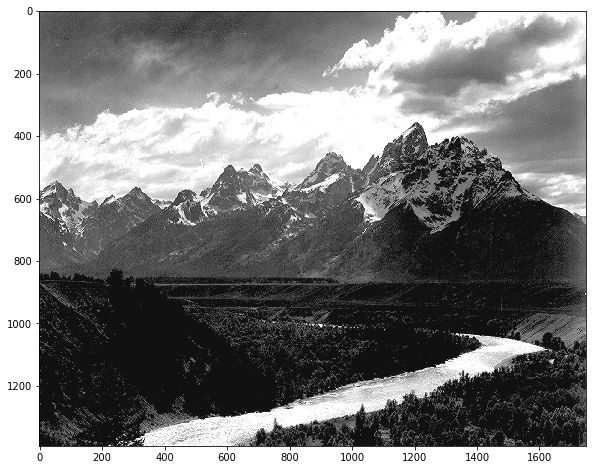

In [61]:
sample_image = cv2.imread('ansel.jpg', 0)
plt.figure(figsize=(12,8))
plt.imshow(sample_image,cmap='gray')

Found 1971 corners on image


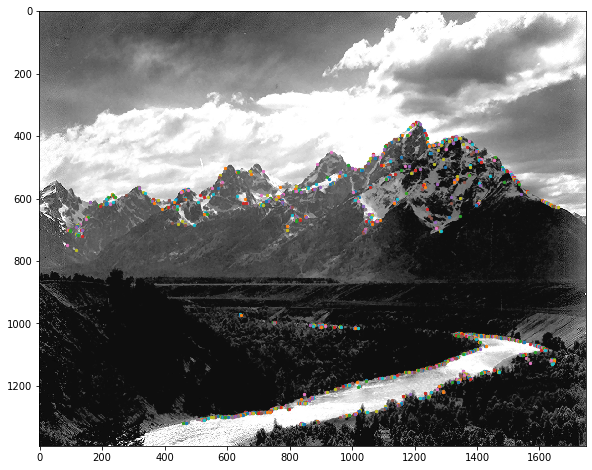

In [64]:
corners = fast_detection(sample_image, threshold = 65)
print("Found %d corners on image" % len(corners))

plt.figure(figsize=(12,8))
implot = plt.imshow(sample_image, cmap='gray')

for corner in corners:
    plt.scatter(corner[0], corner[1], s=5)

plt.show()

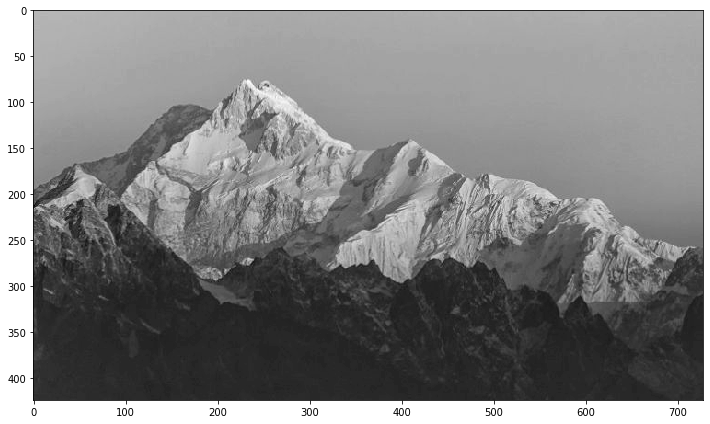

In [65]:
sample_image = cv2.imread('kangchenjunga.jpg', 0)
plt.figure(figsize=(12,8))
plt.imshow(sample_image,cmap='gray')

Found 2494 corners on image


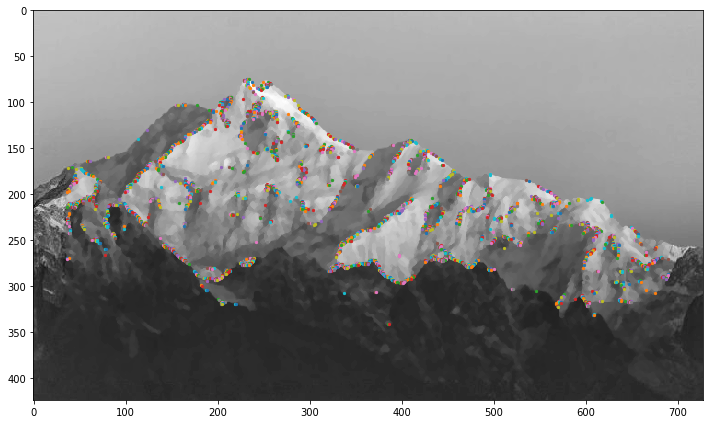

In [68]:
corners = fast_detection(sample_image, threshold = 20)
print("Found %d corners on image" % len(corners))

plt.figure(figsize=(12,8))
implot = plt.imshow(sample_image, cmap='gray')

for corner in corners:
    plt.scatter(corner[0], corner[1], s=5)

plt.show()

As you can see the threshold value was changed for this image due to that with threshold = 50 the number of corners detected was very small.

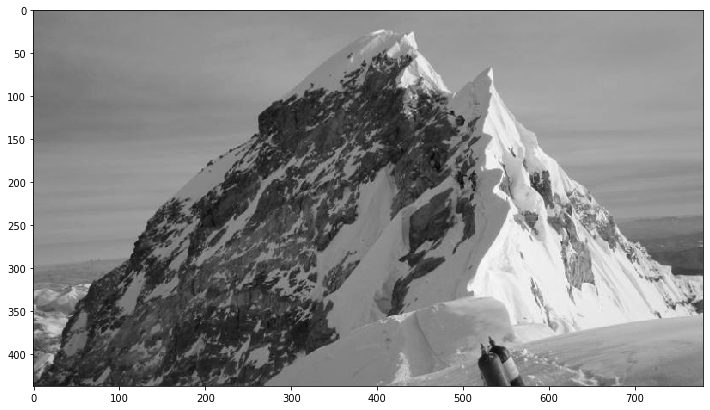

In [69]:
sample_image = cv2.imread('everest.jpg', 0)
plt.figure(figsize=(12,8))
plt.imshow(sample_image,cmap='gray')

Found 1489 corners on image


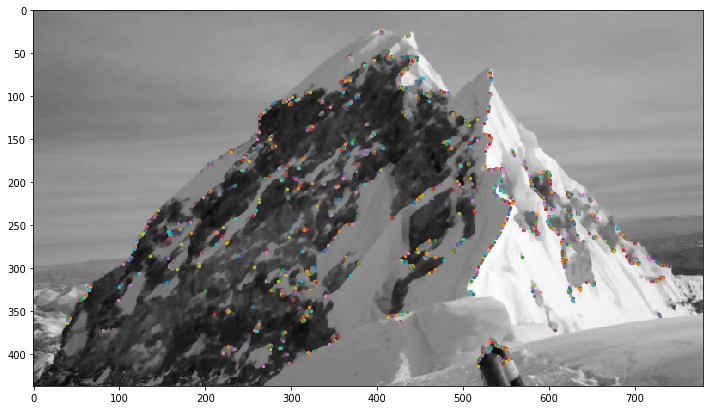

In [71]:
corners = fast_detection(sample_image, threshold = 35)
print("Found %d corners on image" % len(corners))

plt.figure(figsize=(12,8))
implot = plt.imshow(sample_image, cmap='gray')

for corner in corners:
    plt.scatter(corner[0], corner[1], s=5)

plt.show()